# Project: Identify Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that we will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.



In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.



In [2]:
# Load in the general demographics data.
general_population = 'Udacity_AZDIAS_Subset.csv'
gen_pop = pd.read_csv(general_population, sep = ';')

# Load in the feature summary file.
general_population_features = 'AZDIAS_Feature_Summary.csv'
feat_info = pd.read_csv(general_population_features, sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
num_rows, num_cols  = gen_pop.shape
print('Number of columns: {}'.format(num_cols))
print('Number of rows: {}'.format(num_rows))

Number of columns: 85
Number of rows: 891221


In [4]:
#Get the info of general population dataset
display(gen_pop.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

None

In [5]:
#Print the head of the dataset
gen_pop.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Observation:
As we can see in the above result, there are NaN values in the dataset. We will later check out how many missing values are there in the dataset and figure out ways to deal with them. In the mean time, lets check out the "features_info" dataset.

In [6]:
#Print the info of features summary dataset
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [7]:
#Print the head of feat_info
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


#### Oberservation: 
The above result shows us four columns in the "features_info" dataset. The attribute column shows the name of the features of the general population. The "information_level" column tells us whether the information is on the person level or some other level. The "type" column tells us about the type of data of the respective features. The  "missing_or_unkwown" tells us about the missing or unkown values in the respective features.

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Set the index of the feat_info
feat_info.set_index('attribute', inplace=True)

# View the head of the feat_info dataset
feat_info.head()

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


## Lets convert the missing/unknown values into NaNs 
## Also, we will make of note of how much data takes on 'missing' or 'unknown' code and how much data is naturally missing.


In [9]:
# Get the column names of the azdias dataset
col_names = gen_pop.columns

# Check the column_name variable
col_names

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [10]:
# Check in which columns there are natural null values in the gen_pop data frame 
# and store the result in a dataframe
natural_NaN_columns = gen_pop.isnull().any()


In [11]:
# Check the natural_NaN_columns 
print(natural_NaN_columns)

AGER_TYP                 False
ALTERSKATEGORIE_GROB     False
ANREDE_KZ                False
CJT_GESAMTTYP             True
FINANZ_MINIMALIST        False
FINANZ_SPARER            False
FINANZ_VORSORGER         False
FINANZ_ANLEGER           False
FINANZ_UNAUFFAELLIGER    False
FINANZ_HAUSBAUER         False
FINANZTYP                False
GEBURTSJAHR              False
GFK_URLAUBERTYP           True
GREEN_AVANTGARDE         False
HEALTH_TYP               False
LP_LEBENSPHASE_FEIN       True
LP_LEBENSPHASE_GROB       True
LP_FAMILIE_FEIN           True
LP_FAMILIE_GROB           True
LP_STATUS_FEIN            True
LP_STATUS_GROB            True
NATIONALITAET_KZ         False
PRAEGENDE_JUGENDJAHRE    False
RETOURTYP_BK_S            True
SEMIO_SOZ                False
SEMIO_FAM                False
SEMIO_REL                False
SEMIO_MAT                False
SEMIO_VERT               False
SEMIO_LUST               False
                         ...  
OST_WEST_KZ               True
WOHNLAGE

### Observation: By looking at the above result, it seems a lot of columns have naturally occuring missing values. Lets take a count of naturally occuring missing values.

In [12]:
# Check the number of missing values in each columns
# And Store it 
num_of_natural_NaNs = pd.DataFrame(gen_pop.isnull().sum())

In [13]:
# Check the values in the dataframe num_of_natural_NaNs
num_of_natural_NaNs

,0
AGER_TYP,0
ALTERSKATEGORIE_GROB,0
ANREDE_KZ,0
CJT_GESAMTTYP,4854
FINANZ_MINIMALIST,0
FINANZ_SPARER,0
FINANZ_VORSORGER,0
FINANZ_ANLEGER,0
FINANZ_UNAUFFAELLIGER,0
FINANZ_HAUSBAUER,0


In [14]:
# Get the total number of naturally occuring missing values in the general population dataset and store it
num_nat_missing = gen_pop.isnull().sum().sum()
num_nat_missing

4896838

#### Observation: There are 4896838 naturally missing values in the general population dataset. Lets get the proportion of naturally occuring missing values in the general population dataset.

In [15]:
# Get the Proportion of naturally occuring missing values
ratio_of_naturally_missing = pd.DataFrame((gen_pop.isnull().sum())/len(gen_pop))
ratio_of_naturally_missing.columns = ['Proportion of Naturally Missing']

In [16]:
ratio_of_naturally_missing*100

,Proportion of Naturally Missing
AGER_TYP,0.000000
ALTERSKATEGORIE_GROB,0.000000
ANREDE_KZ,0.000000
CJT_GESAMTTYP,0.544646
FINANZ_MINIMALIST,0.000000
FINANZ_SPARER,0.000000
FINANZ_VORSORGER,0.000000
FINANZ_ANLEGER,0.000000
FINANZ_UNAUFFAELLIGER,0.000000
FINANZ_HAUSBAUER,0.000000


In [17]:
# Lets take a look at summary of ratio_of_naturally_missing
ratio_of_naturally_missing.describe()

,Proportion of Naturally Missing
count,85.000000
mean,0.064641
std,0.087883
min,0.000000
25%,0.000000
50%,0.020587
75%,0.111060
max,0.655967


#### Observation: We can see that the max number of naturally missing values in the dataset is 65.5% for a particular column and the mean value is 6.4%. 


In [18]:
# First Lets create a copy of the general population dataframe 
gen_pop_flagged = gen_pop.copy()
    

In [19]:
gen_pop_flagged.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [20]:
# Lets create a flag of the naturally missing values of the general population DataFrame
for col in col_names:
    if gen_pop_flagged[col].isnull().any():
        gen_pop_flagged['nm_'+ col] = gen_pop[col].isnull().astype(int)
        #Here 'nm' means naturally missing 

In [21]:
# View the gen_pop_flagged dataframe and check if the missing values are flagged or not
gen_pop_flagged.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,nm_PLZ8_ANTG1,nm_PLZ8_ANTG2,nm_PLZ8_ANTG3,nm_PLZ8_ANTG4,nm_PLZ8_BAUMAX,nm_PLZ8_HHZ,nm_PLZ8_GBZ,nm_ARBEIT,nm_ORTSGR_KLS9,nm_RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,1,1,1,1,1,1,1,1,1,1
1,-1,1,2,5.0,1,5,2,5,4,5,...,0,0,0,0,0,0,0,0,0,0
2,-1,3,2,3.0,1,4,1,2,3,5,...,0,0,0,0,0,0,0,0,0,0
3,2,4,2,2.0,4,2,5,2,1,2,...,0,0,0,0,0,0,0,0,0,0
4,-1,3,1,5.0,4,3,4,1,3,2,...,0,0,0,0,0,0,0,0,0,0
5,3,1,2,2.0,3,1,5,2,2,5,...,0,0,0,0,0,0,0,0,0,0
6,-1,2,2,5.0,1,5,1,5,4,3,...,0,0,0,0,0,0,0,0,0,0
7,-1,1,1,3.0,3,3,4,1,3,2,...,0,0,0,0,0,0,0,0,0,0
8,-1,3,1,3.0,4,4,2,4,2,2,...,0,0,0,0,0,0,0,0,0,0
9,-1,3,2,4.0,2,4,2,3,5,4,...,0,0,0,0,0,0,0,0,0,0


##### Observation: We can see that columns are created starting with 'nm_' followed by the feature names that have one's if there is a missing value and zero's if there is no missing value for that particular observation.

### Now, we will identify missing or unkown values and covert them to NaNs. Also, we will create columns that will flag these observations of converted missing values. 

In [22]:
feat_info.head()

,information_level,type,missing_or_unknown
attribute,,,
AGER_TYP,person,categorical,"[-1,0]"
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
ANREDE_KZ,person,categorical,"[-1,0]"
CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,person,ordinal,[-1]


In [ ]:
# Identify missing or unknown data values and convert them to NaNs.
for col in column_names:
    gen_pop[col] = gen_pop[col].map(lambda x: np.nan if str(x) in feat_info.loc[col].missing_or_unknown else x)

In [ ]:
# Save the file because the above steps takes a lot of time
gen_pop.to_csv('azdias_nan.csv', sep=';', index = False)

In [23]:
# Load the data from "azdias_nan.csv" file into the dataframe azdias
azdias = pd.read_csv('azdias_nan.csv', delimiter=';')

In [24]:
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,NaN,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,NaN,4.0,NaN,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,NaN,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,NaN,5.0,4.0,3.0,4.0,NaN,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Now that all the missing_or_unkwown values are converted into NaNs, lets flag those missing values in a new data frame to keep a reference of them. 

In [25]:
# Create a data frame to flag the missing values
gen_pop_all_flagged = azdias.copy()

In [26]:
gen_pop_all_flagged.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,NaN,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,NaN,4.0,NaN,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,NaN,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,NaN,5.0,4.0,3.0,4.0,NaN,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [27]:
# Flag the missing values in the gen_pop_all_flagged dataframe
for col in col_names:
    if gen_pop_all_flagged[col].isnull().any():
        gen_pop_all_flagged['m_'+ col] = gen_pop_all_flagged[col].isnull().astype(int)
        

In [28]:
# View the gen_pop_all_flagged dataframe
gen_pop_all_flagged.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,m_PLZ8_ANTG1,m_PLZ8_ANTG2,m_PLZ8_ANTG3,m_PLZ8_ANTG4,m_PLZ8_BAUMAX,m_PLZ8_HHZ,m_PLZ8_GBZ,m_ARBEIT,m_ORTSGR_KLS9,m_RELAT_AB
0,NaN,2.0,NaN,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,1,1,1,1,1,1,1,1,1,1
1,NaN,NaN,2.0,5.0,NaN,5.0,2.0,5.0,4.0,5.0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,3.0,2.0,3.0,NaN,4.0,NaN,2.0,3.0,5.0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,NaN,2.0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,3.0,NaN,5.0,4.0,3.0,4.0,NaN,3.0,2.0,...,0,0,0,0,0,0,0,0,0,0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [29]:
# Perform an assessment of how much missing data there is in each column of the dataset
no_of_missing = azdias.isnull().sum()



In [30]:
# Check the number of missing values
no_of_missing

AGER_TYP                 765645
ALTERSKATEGORIE_GROB     145768
ANREDE_KZ                425916
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST        139587
FINANZ_SPARER            250213
FINANZ_VORSORGER         104369
FINANZ_ANLEGER           210812
FINANZ_UNAUFFAELLIGER    220597
FINANZ_HAUSBAUER         143104
FINANZTYP                199572
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               273584
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         792400
PRAEGENDE_JUGENDJAHRE    129446
RETOURTYP_BK_S             4854
SEMIO_SOZ                 62088
SEMIO_FAM                 81916
SEMIO_REL                108130
SEMIO_MAT                 97341
SEMIO_VERT               120437
SEMIO_LUST               110382
                          ...  
OST_WEST

In [31]:
# Check the proportion of missing values in terms of percentage
ratio_of_missing = no_of_missing[no_of_missing > 0]/(len(azdias)) * 100
ratio_of_missing.sort_values(inplace=True)
round(ratio_of_missing,2)

ONLINE_AFFINITAET         0.54
RETOURTYP_BK_S            0.54
LP_STATUS_GROB            0.54
LP_STATUS_FEIN            0.54
LP_FAMILIE_GROB           0.54
LP_LEBENSPHASE_GROB       0.54
LP_LEBENSPHASE_FEIN       0.54
GFK_URLAUBERTYP           0.54
LP_FAMILIE_FEIN           0.54
CJT_GESAMTTYP             0.54
HH_EINKOMMEN_SCORE        2.06
SEMIO_ERL                 4.79
SEMIO_DOM                 5.02
SEMIO_RAT                 5.25
SEMIO_KAEM                5.30
SEMIO_KRIT                6.17
SEMIO_SOZ                 6.97
ALTER_HH                  8.25
ANZ_PERSONEN              8.25
SOHO_KZ                   8.25
ANZ_TITEL                 8.25
TITEL_KZ                  8.25
WOHNDAUER_2008            8.25
KONSUMNAEHE               8.30
SEMIO_PFLICHT             8.32
SEMIO_FAM                 9.19
WOHNLAGE                 10.45
OST_WEST_KZ              10.45
MIN_GEBAEUDEJAHR         10.45
GEBAEUDETYP              10.45
                         ...  
PLZ8_GBZ                 13.07
SEMIO_VE

#### Looking at the above results it seems like there is a lot of variation in the proportion of missing values for each feature. Lets make a histogram of the percentage of missing value and check for outliers.

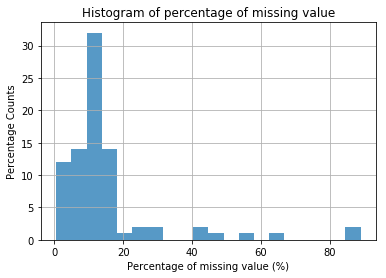

In [32]:
#Plotting the distribution of percentage of missing value
plt.hist(ratio_of_missing, bins=20, alpha=0.75)

# Labels for the plot
plt.grid(True)
plt.xlabel('Percentage of missing value (%)')
plt.ylabel('Percentage Counts')
plt.title('Histogram of percentage of missing value')
plt.show()

In [34]:
sns.set(color_codes=True)


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


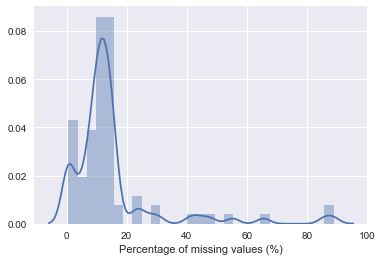

In [35]:
# Plot histogram with kde
sns.distplot(ratio_of_missing, bins = 'fd',  axlabel="Percentage of missing values (%)" )


#### Observation: 

From the histogram we can observe that the data can be assumed to be normally distributed till 20% of missing values. After the 20% mark, the percentage of missing values are outliers. Now, we will further analyse the features with above 20% missing value and decide whether we will drop it or not. Before that, lets further explore the features by constructing a bar plot of all the column with missing values and their percentage.

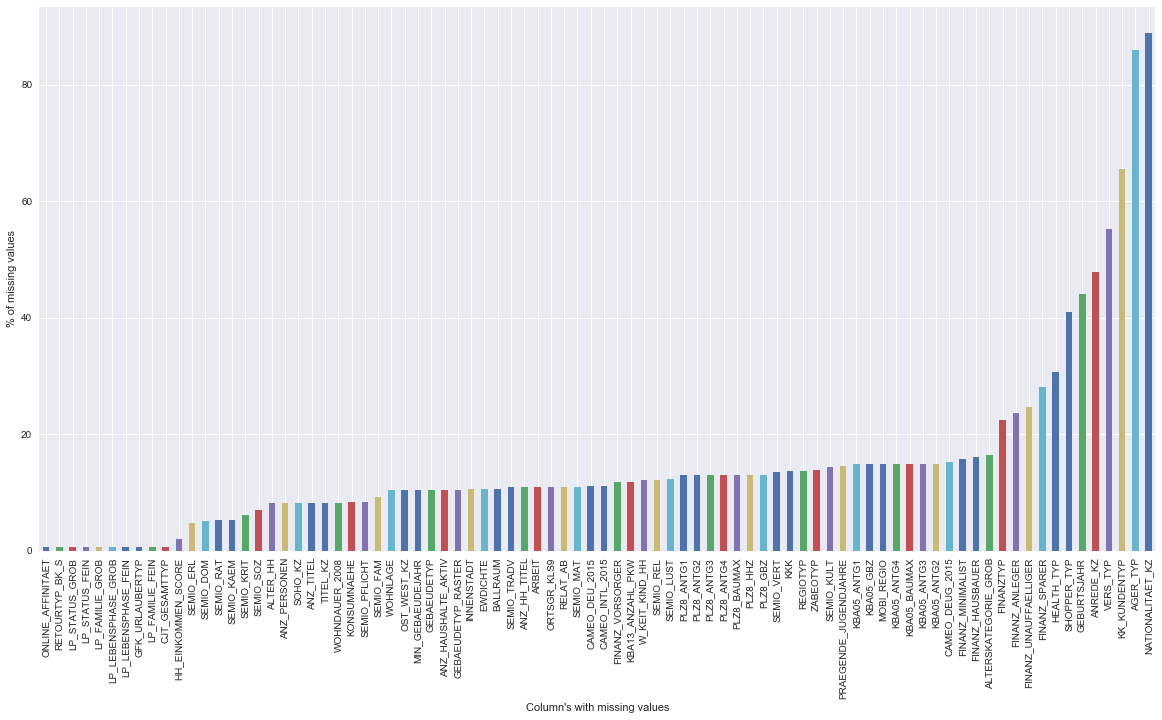

84 columns have missing values.


In [36]:
# Plot a bar graph
ratio_of_missing.plot.bar(figsize=(20,10))
plt.xlabel('Column\'s with missing values')
plt.ylabel('% of missing values')

plt.show()
print("{} columns have missing values.".format(len(ratio_of_missing)))

#### As we can observe from the above chart, 12 features have missing values greater than 20%

In [37]:
# Find the columns with more than 20% missing values
outlier_columns = [col for col in col_names if (azdias[col].isnull().sum()/len(azdias)) * 100 > 20]
print(outlier_columns)



['AGER_TYP', 'ANREDE_KZ', 'FINANZ_SPARER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZTYP', 'GEBURTSJAHR', 'HEALTH_TYP', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'KK_KUNDENTYP']


#### The above columns with missing values greater than 20% represent the following:
1. AGER_TYP -> Best-ager typology
2. ANREDE_KZ -> Gender
3. FINANZ_SPARER -> Financial money-saver
4. FINANZ_ANLEGER -> Financial investor
5. FINANZ_UNAUFFAELLIGER -> Financial Inconspicious
6. FINANZTYP -> Most descriptive financial type for individual
7. GEBURTSJAHR -> Year of Birth
8. HEALTH_TYP -> Health typology
9. NATIONALITAET_KZ -> Nationality based on given name analysis
10. SHOPPER_TYP -> Shopper typology 
11. VERS_TYP -> Insurance typology
12. KK_KUNDENTYP -> Consumer pattern over past 12 months


#### Observation:

If we observe the above bar chart and take a look at the data dictionary, some of the columns with missing value more than 20% stored in the variable "missing_value_greater_than_20" seems important. Eg: "GEBURTSJAHR" displays year of birth, "ANREDE_KZ" displays gender, "KK_KUNDENTYP" gives information about the consumer pattern over the past 12months.  But, it seems impractical to impute those values because we can't replicate it with conditions from any other country and also because the regions in the same country might have different variations in different regions in their population. Also, trying to impute the missing values to these columns will result in more bias in the model. Hence, we are going to drop these features from the data frame i.e we are dropping all the columns which have missing values greater than 20%

In [38]:
# Make a copy of the azdias dataframe
gen_pop_dropped = azdias.copy()

In [39]:
# Remove the outlier columns from the dataset. (We'll perform other data
# engineering tasks such as re-encoding and imputation later.)
gen_pop_dropped = gen_pop_dropped.drop(columns = outlier_columns, axis = 1)
    

In [40]:
# View the gen_pop_dropped dataframe and verify the number of columns 
gen_pop_dropped.head()

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,2.0,3.0,3.0,3.0,10.0,0,15.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,5.0,NaN,2.0,5.0,10.0,0,21.0,6.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,3.0,NaN,NaN,5.0,10.0,1,3.0,1.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,4.0,5.0,2.0,1.0,0,0.0,0.0,0.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,5.0,4.0,4.0,2.0,5.0,0,32.0,10.0,10.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [41]:
# Check the number of observation in the gen_pop_dropped dataframe
len(gen_pop_dropped)

891221

#### As we can observe from the above results the columns were dropped, the number of observations(rows) remain the same

#### Discussion 1.1.2: Assess Missing Data in Each Column. 

We observed that except one column, all the columns have a missing values. Those values range from 0.5% to 88% in proportion to the number of observations of the whole dateset. From the above plots, we found out that 9 columns have ~0.54% missing values and the percentage keeps increasing till ~15% for most of the columns and then decreases. This shows normal distribution behaviour till 20% of missing values. Then, by observing the above plots, we removed the columns with more than 20% of missing values because they were outliers and imputing them might introduce additional bias in the model. The columns removed are :  ['AGER_TYP', 'ANREDE_KZ', 'FINANZ_SPARER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZTYP', 'GEBURTSJAHR', 'HEALTH_TYP', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'KK_KUNDENTYP']



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [42]:
# How much missing data is there in a row 
missing_values_row = gen_pop_dropped.isnull().sum(axis=1)

In [43]:
missing_values_row

0         43
1          3
2          3
3          3
4          0
5          1
6          2
7          4
8          3
9          4
10         1
11        43
12         9
13        12
14        43
15         9
16         5
17        43
18         3
19         1
20        12
21         2
22         2
23        11
24        43
25         4
26        23
27         1
28         1
29         3
          ..
891191     0
891192     2
891193     0
891194     2
891195     5
891196     2
891197     4
891198     2
891199     0
891200     3
891201     1
891202     2
891203    14
891204     4
891205     0
891206     3
891207     3
891208     3
891209     3
891210     1
891211     0
891212     3
891213     0
891214     3
891215     1
891216     6
891217     0
891218     1
891219     2
891220     0
Length: 891221, dtype: int64

In [44]:
missing_values_row.describe()

count    891221.000000
mean          7.014282
std          12.346019
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max          50.000000
dtype: float64

In [45]:
# Proportion of missing values in  each row
ratio_of_mv_row = round((missing_values_row[missing_values_row > 0] / gen_pop_dropped.shape[1]) * 100, 2)
ratio_of_mv_row.sort_values(inplace = True)

In [46]:
ratio_of_mv_row.describe()

count    798372.000000
mean         10.726069
std          17.529013
min           1.370000
25%           2.740000
50%           4.110000
75%           6.850000
max          68.490000
dtype: float64

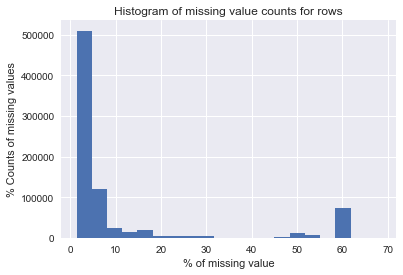

In [47]:
# Plot a histogram of Percentage of missing values per row
plt.hist(ratio_of_mv_row, bins = 20 )
plt.xlabel('% of missing value')
plt.ylabel('% Counts of missing values')
plt.title('Histogram of missing value counts for rows')
plt.show()

#### Observation and Discussion: Looking at the above histogram and the results of ratio_of_mv_row we found out that the % of missing values for rows varies from 1.37% to 68.49%. The distribution of graph initially looks like exponentially decreasing and then there seems to be some outliers after 20%. Lets divide the dataset into two subsets. One with missing values greater than or equal to 3 and other with number of missing values less than 3.

In [48]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Rows with less than 3 missing values
below_threshold = gen_pop_dropped[gen_pop_dropped.isnull().sum(axis=1) < 3].reset_index(drop = True)

# Dataset of rows with missing values greater than or equal to 3
above_threshold = gen_pop_dropped[gen_pop_dropped.isnull().sum(axis=1) >= 3].reset_index(drop = True)

In [49]:
below_threshold.head()

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,3.0,5.0,4.0,4.0,2.0,5.0,0,32.0,10.0,10.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
1,NaN,2.0,3.0,5.0,5.0,1.0,0,8.0,2.0,1.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
2,2.0,5.0,NaN,NaN,3.0,12.0,0,2.0,1.0,1.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
3,3.0,1.0,2.0,5.0,5.0,8.0,0,6.0,2.0,1.0,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0
4,3.0,3.0,5.0,3.0,NaN,8.0,1,20.0,5.0,2.0,...,2.0,4.0,2.0,1.0,2.0,5.0,4.0,4.0,6.0,3.0


In [50]:
above_threshold.head()

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,2.0,3.0,3.0,3.0,10.0,0,15.0,4.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,5.0,NaN,2.0,5.0,10.0,0,21.0,6.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,3.0,NaN,NaN,5.0,10.0,1,3.0,1.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,4.0,5.0,2.0,1.0,0,0.0,0.0,0.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,3.0,4.0,2.0,9.0,0,5.0,2.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0


In [51]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
column_names_below_threshold = below_threshold.columns

def plot_countplot(column_names, number_of_columns):
    
    figure, axis = plt.subplots(number_of_columns, 2, figsize = (25,25), facecolor='white', edgecolor='black')
    figure.subplots_adjust(hspace = 2, wspace = .2)
    axis = axis.ravel()
    
    for i in range(number_of_columns):
        sns.countplot(below_threshold[column_names[i]], ax = axis[i*2])
        axis[i*2].set_title('Below Threshold (Less than 3 Missing Values)')
        
        sns.countplot(above_threshold[column_names[i]], ax = axis[i*2+1])
        axis[i*2+1].set_title('Above Threshold (Greater than or equal to 3 Missing Values)')
        
        

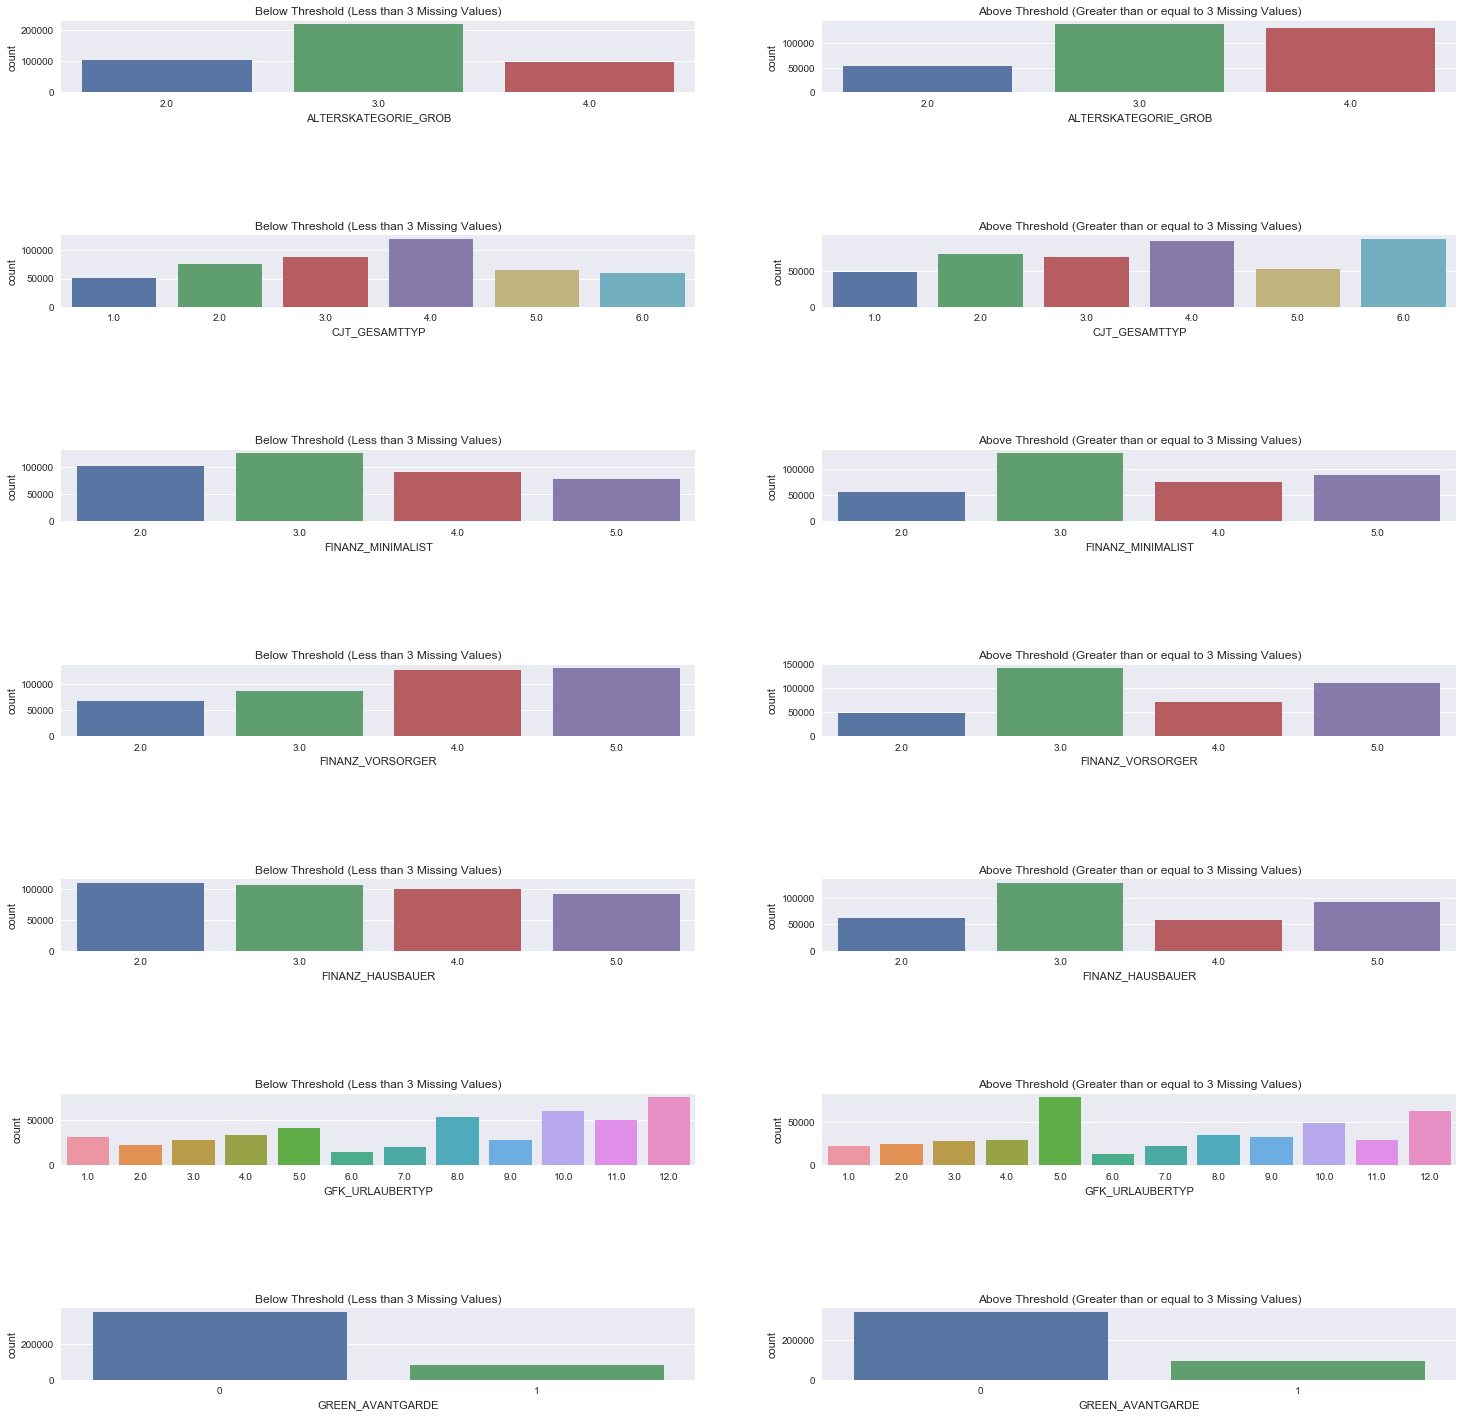

In [52]:
# Plot the countplot to compare the distribution of data between the two subsets 
plot_countplot(column_names_below_threshold, 7)

#### Discussion 1.1.3: Assess Missing Data in Each Row 

#### Looking at summary of  "missing value counts" in rows we can see the 75% Quartile starts from number of missing values = 4 and the 50% Quartile is at number of missing values = 2. That is why, I set the threshold to  missing values number = 3 in each row and I plot the countplot for 7 columns that are having no missing values(or few missing).  It seems that the data with missing values  above threshold does not look very different from the data with missing values below threshold. Therefore, dropping those points with many missing values from the analysis won't lead to a major issue.

Now, to deal with the remaining missing values, we have two options:

1. Drop all the missing values:
    - If we drop all the missing values, we lose almost 80% of the data. We would end up with almost 92000 rows. This is too small compared to the total amount of data we had. 

2. Imputing the missing values with the mode of each column:
    - If we do this, then we have about 459406 rows, which is approximately 50% of the original data that we had. Here the problem is that we don't know whether imputing the missing value with mode is the best way. 

Lets go ahead with the second method since we don't want to miss on a lot of data




In [53]:
#filling missing values with the mode
for col in below_threshold.columns:
    below_threshold[col] = below_threshold[col].fillna(below_threshold[col].mode()[0])

In [54]:
# Check that all the missing values are filled
below_threshold.isnull().any().any()

False

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [55]:
feat_info['column_names'] = feat_info.index


In [56]:
feat_info.head()

,information_level,type,missing_or_unknown,column_names
attribute,,,,
AGER_TYP,person,categorical,"[-1,0]",AGER_TYP
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",ALTERSKATEGORIE_GROB
ANREDE_KZ,person,categorical,"[-1,0]",ANREDE_KZ
CJT_GESAMTTYP,person,categorical,[0],CJT_GESAMTTYP
FINANZ_MINIMALIST,person,ordinal,[-1],FINANZ_MINIMALIST


In [57]:
# Print the number of features of each data type 
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

### Discussion:
The above results shows the number of different types of features. However, note that we have dropped some columns which we outliers. Hence, we will create a drop those feature's column name from the feat_info dataframe too. Then we will calculate the number of different types of features

In [58]:
outlier_columns

['AGER_TYP',
 'ANREDE_KZ',
 'FINANZ_SPARER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZTYP',
 'GEBURTSJAHR',
 'HEALTH_TYP',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'KK_KUNDENTYP']

In [59]:
# Create a new features summary dataframe
features_info = feat_info.copy()


In [60]:
features_info.head()

,information_level,type,missing_or_unknown,column_names
attribute,,,,
AGER_TYP,person,categorical,"[-1,0]",AGER_TYP
ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",ALTERSKATEGORIE_GROB
ANREDE_KZ,person,categorical,"[-1,0]",ANREDE_KZ
CJT_GESAMTTYP,person,categorical,[0],CJT_GESAMTTYP
FINANZ_MINIMALIST,person,ordinal,[-1],FINANZ_MINIMALIST


In [61]:
# Check the shape of features_info dataframe
features_info.shape

(85, 4)

In [62]:
# Remove the outlier columns from the features_info dataframe
features_info = features_info.drop(index = outlier_columns)

In [63]:
# Check the shape of features_info dataframe after dropping the outlier columns index 
features_info.shape

(73, 4)

In [64]:
# Print the total number of different datatypes for different features
features_info['type'].value_counts()

ordinal        45
categorical    14
mixed           7
numeric         6
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [65]:
# Empty list to store the names of the categorical variables
categorical_variables = []

# Get the names of the categorical variables 
for col in below_threshold.columns:
    if features_info.loc[col].type == "categorical":
        categorical_variables.append(col)

In [66]:
# Check the names of the categorical variables
categorical_variables

['CJT_GESAMTTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'SOHO_KZ',
 'TITEL_KZ',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [67]:
# Verify the number of categorical variables
len(categorical_variables)

14

#### Brief Description of the above categorical variables:
1. CJT_GESAMTTYP -> Customer-Journey-Typology: preferred information and buying channels for consumer
2. GFK_URLAUBERTYP -> Vacation habits 
3. GREEN_AVANTGARDE -> Membership in environmental sustainability as part of youth
4. LP_FAMILIE_FEIN -> Family type, fine scale
5. LP_FAMILIE_GROB -> Family type, rough scale
6. LP_STATUS_FEIN -> Social status, fine scale
7. LP_STATUS_GROB -> Social status, rough scale
8. SOHO_KZ -> Small office / home office flag
9. TITEL_KZ -> Academic title flag
10. ZABEOTYP -> Energy consumption topology
11. GEBAEUDETYP -> Type of building (residential vs. commercial)
12. OST_WEST_KZ ->  Building location via former East / West Germany (GDR / FRG)
13. CAMEO_DEUG_2015 -> German CAMEO: Wealth / Life Stage Typology, rough scale
14. CAMEO_DEU_2015 -> German CAMEO: Wealth / Life Stage Typology, detailed scale
 

In [70]:
# Check the categories levels of different categorical variables and their datatype
for col in categorical_variables:
    print(col, end = " ")
    print(len(below_threshold[col].unique()), below_threshold[col].dtype)

CJT_GESAMTTYP 6 float64
GFK_URLAUBERTYP 12 float64
GREEN_AVANTGARDE 2 int64
LP_FAMILIE_FEIN 12 float64
LP_FAMILIE_GROB 6 float64
LP_STATUS_FEIN 10 float64
LP_STATUS_GROB 5 float64
SOHO_KZ 2 float64
TITEL_KZ 6 float64
ZABEOTYP 5 float64
GEBAEUDETYP 7 float64
OST_WEST_KZ 2 object
CAMEO_DEUG_2015 8 float64
CAMEO_DEU_2015 44 object


#### Observation: From the above result we can see that, the features "GREEN_AVANTGARDE", "SOHO_KZ", and "OST_WEST_KZ" . From these features, "OST_WEST_KZ" is a binary categorical feature which does not take numeric values. We will only convert the "OST_WEST_KZ" feature into a dummy variable. Also, after looking at the data dictionary, we observed that the including the multicategory features will make the clusters too specific because there are a lot of different categories within one variable. Hence we have decided to drop the categorical features with more than 2 categories

In [72]:
# Store categorical variables with more than 2 categories in the following variable
multi_cat = [] 
for col in categorical_variables:
    if len(below_threshold[col].unique()) > 2 :
        multi_cat.append(col)
        

In [73]:
# View multi_cat
multi_cat

['CJT_GESAMTTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'TITEL_KZ',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [74]:
# Copy the below_threshold dataframe 
gen_pop_data_wrangling = below_threshold.copy()

In [75]:
gen_pop_data_wrangling.head()

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,3.0,5.0,4.0,4.0,2.0,5.0,0,32.0,10.0,10.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
1,3.0,2.0,3.0,5.0,5.0,1.0,0,8.0,2.0,1.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
2,2.0,5.0,3.0,5.0,3.0,12.0,0,2.0,1.0,1.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
3,3.0,1.0,2.0,5.0,5.0,8.0,0,6.0,2.0,1.0,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0
4,3.0,3.0,5.0,3.0,2.0,8.0,1,20.0,5.0,2.0,...,2.0,4.0,2.0,1.0,2.0,5.0,4.0,4.0,6.0,3.0


In [76]:
# Drop features with more than 2 categories
gen_pop_data_wrangling = gen_pop_data_wrangling.drop(columns = multi_cat, axis = 1)

In [77]:
# View the gen_pop_data_wrangling dataframe after dropping the multi_cat features
gen_pop_data_wrangling.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,3.0,4.0,4.0,2.0,0,32.0,10.0,8.0,5.0,6.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
1,3.0,3.0,5.0,5.0,0,8.0,2.0,3.0,3.0,2.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
2,2.0,3.0,5.0,3.0,0,2.0,1.0,10.0,4.0,2.0,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
3,3.0,2.0,5.0,5.0,0,6.0,2.0,3.0,5.0,5.0,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0
4,3.0,5.0,3.0,2.0,1,20.0,5.0,9.0,5.0,3.0,...,2.0,4.0,2.0,1.0,2.0,5.0,4.0,4.0,6.0,3.0


In [78]:
# store the non-numeric binary categorical variable name in the following object
one_hot_cat_var = ['OST_WEST_KZ']

In [79]:
# One-hot encode the one_hot_cat_var features
gen_pop_data_wrangling = pd.get_dummies(data = gen_pop_data_wrangling, columns = one_hot_cat_var)

In [80]:
# View the dataframe
gen_pop_data_wrangling.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W
0,3.0,4.0,4.0,2.0,0,32.0,10.0,8.0,5.0,6.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1
1,3.0,3.0,5.0,5.0,0,8.0,2.0,3.0,3.0,2.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1
2,2.0,3.0,5.0,3.0,0,2.0,1.0,10.0,4.0,2.0,...,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0,1
3,3.0,2.0,5.0,5.0,0,6.0,2.0,3.0,5.0,5.0,...,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1
4,3.0,5.0,3.0,2.0,1,20.0,5.0,9.0,5.0,3.0,...,2.0,1.0,2.0,5.0,4.0,4.0,6.0,3.0,0,1


#### Discussion 1.2.1: Re-Encode Categorical Features

In the above section, we found out the categorical features with binary, non-numeric binary, and more than 2 categories. We decided to keep the binary categorical features the same and convert the non-numeric binary. Also, We dropped the categorical variables with more than 2 categories 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [82]:
# How many different types of features are present?
features_info['type'].value_counts()

ordinal        45
categorical    14
mixed           7
numeric         6
interval        1
Name: type, dtype: int64

In [83]:
# Store the mixed features names in the following object
mix_features = []

for col in below_threshold.columns:
    if features_info.loc[col].type == 'mixed':
        mix_features.append(col)

In [84]:
# View the list of features with mixed type
mix_features

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

##### Brief Description of the unique categories of PRAEGENDE_JUGENDJAHRE feature
### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [ ]:
"""From the above brief description of the PRAEGENDE_JUGENDJAHRE feature and from the previous instructions above,
we can observe that the feature contains combines information on three dimensions: generation by decade, 
movement (mainstream vs. avantgarde), and nation (east vs. west). We will create two new variables to capture the other 
two dimensions: an interval-type variable for decade, and a binary variable for movement."""

In [85]:
def decade(n):
    """This function will help to create the decade variable."""

    if n in (1,2):
        return 1
    if n in (3,4):
        return 2
    if n in (5,6,7):
        return 3
    if n in (8,9):
        return 4
    if n in (10,11,12,13):
        return 5
    if n in (14,15):
        return 6
    
    
def movement(m):
    """This function will help to create the movement variable."""
    
    # we will convert every "Avantgarde" to 0 and "Mainstream" to 1
    if m in (2,4,6,7,9,11,13,15):
        return 0
    if m in (1,3,5,8,10,12,14):
        return 1


In [86]:
# Create a copy of the gen_pop_data_wrangling dataframe
gen_pop_dw2 = gen_pop_data_wrangling.copy()

"""NOTE: we are making new copies because if we make an error, we can refer back to the previous dataset and 
refer to it and start the process again."""

'NOTE: we are making new copies because if we make an error, we can refer back to the previous dataset and \nrefer to it and start the process again.'

In [87]:
gen_pop_dw2.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W
0,3.0,4.0,4.0,2.0,0,32.0,10.0,8.0,5.0,6.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1
1,3.0,3.0,5.0,5.0,0,8.0,2.0,3.0,3.0,2.0,...,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0,1
2,2.0,3.0,5.0,3.0,0,2.0,1.0,10.0,4.0,2.0,...,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0,1
3,3.0,2.0,5.0,5.0,0,6.0,2.0,3.0,5.0,5.0,...,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0,0,1
4,3.0,5.0,3.0,2.0,1,20.0,5.0,9.0,5.0,3.0,...,2.0,1.0,2.0,5.0,4.0,4.0,6.0,3.0,0,1


In [88]:
# Apply the "decade" function on the gen_pop_dw2['PRAEGENDE_JUGENDJAHRE']
gen_pop_dw2['decade_PRAEGENDE_JUGENDJAHRE'] = gen_pop_dw2['PRAEGENDE_JUGENDJAHRE'].apply(decade) 

In [89]:
# Apply the "movement" function on the gen_pop_dw2['PRAEGENDE_JUGENDJAHRE']
gen_pop_dw2['movement_PRAEGENDE_JUGENDJAHRE'] = gen_pop_dw2['PRAEGENDE_JUGENDJAHRE'].apply(movement)

In [90]:
# Drop the "PRAEGENDE_JUGENDJAHRE" feature from the gen_pop_dw2 dataframe
gen_pop_dw2 = gen_pop_dw2.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], axis = 1)

In [92]:
# View the dataset
gen_pop_dw2.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,decade_PRAEGENDE_JUGENDJAHRE,movement_PRAEGENDE_JUGENDJAHRE
0,3.0,4.0,4.0,2.0,0,32.0,10.0,5.0,6.0,4.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0,1,4,1
1,3.0,3.0,5.0,5.0,0,8.0,2.0,3.0,2.0,4.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0,1,2,1
2,2.0,3.0,5.0,3.0,0,2.0,1.0,4.0,2.0,5.0,...,1.0,5.0,5.0,4.0,6.0,3.0,0,1,5,1
3,3.0,2.0,5.0,5.0,0,6.0,2.0,5.0,5.0,2.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0,1,2,1
4,3.0,5.0,3.0,2.0,1,20.0,5.0,5.0,3.0,5.0,...,2.0,5.0,4.0,4.0,6.0,3.0,0,1,4,0


#### Brief description of "CAMEO_INTL_2015"
#### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code

- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement


In [ ]:
"""The second feature that we need to pay to attention to is CAMEO_INTL_2015. 
Here "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. 
We will break up the two-digit codes by their 'tens'-place and 'ones'-place digits into 
two new ordinal variables (which, for the purposes of this project, is equivalent to just
treating them as their raw numeric values). We will create two functions named wealth and lifeStage 
that will help us to dissect and store the seperate information that we need."""

In [93]:
def wealth(m):
    """This function floors the value of the quotient. Using this function we will create the wealth feature """
    if int(m) // 10 ==1:
        return 1
    if int(m) // 10 ==2:
        return 2
    if int(m) // 10 ==3:
        return 3
    if int(m) // 10 ==4:
        return 4
    if int(m) // 10 ==5:
        return 5
    
def lifeStage(s):
    """This function calculates the modulo and compares it to return the value we need. Using this function we will create the life-stage feature"""
    if int(s) % 10 ==1:
        return 1
    if int(s) % 10 ==2:
        return 2
    if int(s) % 10 ==3:
        return 3
    if int(s) % 10 ==4:
        return 4
    if int(s) % 10 ==5:
        return 5


In [94]:
# Apply the wealth function on the CAMEO_INTL_2015 feature of the dataset
gen_pop_dw2['wealth_CAMEO_INTL_2015'] = gen_pop_dw2['CAMEO_INTL_2015'].apply(wealth)

In [95]:
# Apply the lifeStage function on the CAMEO_INTL_2015 feature of the dataset
gen_pop_dw2['lifeStage_CAMEO_INTL_2015'] = gen_pop_dw2['CAMEO_INTL_2015'].apply(lifeStage)

In [96]:
# Drop the CAMEO_INTL_2015 column 
gen_pop_dw2 = gen_pop_dw2.drop(columns = ['CAMEO_INTL_2015'], axis = 1)

In [97]:
# View the dataset
gen_pop_dw2.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,decade_PRAEGENDE_JUGENDJAHRE,movement_PRAEGENDE_JUGENDJAHRE,wealth_CAMEO_INTL_2015,lifeStage_CAMEO_INTL_2015
0,3.0,4.0,4.0,2.0,0,32.0,10.0,5.0,6.0,4.0,...,3.0,4.0,6.0,5.0,0,1,4,1,4,3
1,3.0,3.0,5.0,5.0,0,8.0,2.0,3.0,2.0,4.0,...,5.0,2.0,3.0,3.0,0,1,2,1,5,4
2,2.0,3.0,5.0,3.0,0,2.0,1.0,4.0,2.0,5.0,...,5.0,4.0,6.0,3.0,0,1,5,1,2,2
3,3.0,2.0,5.0,5.0,0,6.0,2.0,5.0,5.0,2.0,...,3.0,4.0,6.0,5.0,0,1,2,1,5,1
4,3.0,5.0,3.0,2.0,1,20.0,5.0,5.0,3.0,5.0,...,4.0,4.0,6.0,3.0,0,1,4,0,3,4


In [98]:
mix_features

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [99]:
# Remove the 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' from the mix_features list as they are already delt with
mix_features.remove('PRAEGENDE_JUGENDJAHRE')
mix_features.remove('CAMEO_INTL_2015')

In [100]:
mix_features

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'WOHNLAGE',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

##### NOTE:
We checked the other 5 mixed features and observed that there are not enough levels to seperate different values. Hence we have decided to remove those features



In [101]:
# Drop the columns in mix_features from less_missing dataframe
gen_pop_dw2 = gen_pop_dw2.drop(columns = mix_features, axis = 1)

In [102]:
gen_pop_dw2.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,decade_PRAEGENDE_JUGENDJAHRE,movement_PRAEGENDE_JUGENDJAHRE,wealth_CAMEO_INTL_2015,lifeStage_CAMEO_INTL_2015
0,3.0,4.0,4.0,2.0,0,5.0,6.0,4.0,4.0,2.0,...,3.0,4.0,6.0,5.0,0,1,4,1,4,3
1,3.0,3.0,5.0,5.0,0,3.0,2.0,4.0,7.0,4.0,...,5.0,2.0,3.0,3.0,0,1,2,1,5,4
2,2.0,3.0,5.0,3.0,0,4.0,2.0,5.0,5.0,7.0,...,5.0,4.0,6.0,3.0,0,1,5,1,2,2
3,3.0,2.0,5.0,5.0,0,5.0,5.0,2.0,3.0,5.0,...,3.0,4.0,6.0,5.0,0,1,2,1,5,1
4,3.0,5.0,3.0,2.0,1,5.0,3.0,5.0,4.0,4.0,...,4.0,4.0,6.0,3.0,0,1,4,0,3,4


#### Discussion 1.2.2: Engineer Mixed-Type Features. 

For the mixed-type features, we segregated the PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 into 4 new features: decade, movement, wealth, lifeStage. Then we dropped the original  CAMEO_INTL_2015 and PRAEGENDE_JUGENDJAHRE since its values won't be useful for the algorithm. After that, we observed the values of the other mixed-types and found out that there are not enough levels to seperate different values. Hence we decided to drop those columns. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Note: The steps performed above are sufficient for complete feature selection



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [104]:
def convert_to_NaN(df):
    """This function finds the missing_or_unknown values and converts them to NaNs"""
    
    for col in df.columns:
        df[col] = df[col].map(lambda x: np.nan if str(x) in feat_info.loc[col].missing_or_unknown else x)

    return df

def drop_columns_rows(df):
    """This function drops/filters the columns and rows of the dataframe"""
    
    drop_columns = outlier_columns
    
    # Drop columns
    df = df.drop(columns = drop_columns, axis = 1)
    
    # Drop the multi_cat columns 
    df = df.drop(data = df, columns = multi_cat)
    
    # Filter the rows
    df = df[df.isnull().sum(axis = 1) < 3].reset_index(drop = True)
    
    return df



def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = convert_to_NaN(df)
     
    # remove selected columns and rows, ...
    df = drop_columns_rows(df)
    
    # Impute missing values 
    for col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    # select, re-encode, and engineer column values.
    # one-hot encode categorical variables
    df = pd.get_dummies(data = df, columns = one_hot_cat_var) 
    
    # re-encode and engineer the mixed datatype features
    # Apply the decade function to the 'PRAEGENDE_JUGENDJAHRE' features column
    df['decade_PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(decade) 
    # Apply the movement function to the 'PRAEGENDE_JUGENDJAHRE' features column
    df['movement_PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(movement)
    # Drop the 'PRAEGENDE_JUGENDJAHRE' column 
    df = df.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], axis = 1)
    
    
    # Apply the wealth function on the CAMEO_INTL_2015 feature of the dataset
    df['wealth_CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(wealth)
    # Apply the lifeStage function on the CAMEO_INTL_2015 feature of the dataset
    df['lifeStage_CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].apply(lifeStage)
    # Drop the CAMEO_INTL_2015 column 
    df = df.drop(columns = ['CAMEO_INTL_2015'], axis = 1)
    
    # Drop the other 5 mixed features datatype 
    df = df.drop(columns = mix_features, axis = 1)
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [105]:
# Check that data does not have any missing values
gen_pop_dw2.isnull().any().any()

False

In [106]:
# Create a copy of the gen_pop_dw2 dataframe for reference. 
gen_pop_dw3 = gen_pop_dw2.copy()

In [107]:
# Import the necessary libraries 
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()

In [108]:
# Apply feature scaling to the general population demographics data.
gen_pop_dw3[gen_pop_dw3.columns] = scale.fit_transform(gen_pop_dw3[gen_pop_dw3.columns].values)

In [109]:
gen_pop_dw3.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,decade_PRAEGENDE_JUGENDJAHRE,movement_PRAEGENDE_JUGENDJAHRE,wealth_CAMEO_INTL_2015,lifeStage_CAMEO_INTL_2015
0,0.019590,0.677447,0.091997,-1.109296,-0.470793,1.017392,0.901737,-0.275462,-0.201614,-1.368303,...,-0.291169,0.803020,0.249761,1.372191,-0.507563,0.507563,-0.275037,0.470793,0.399545,0.177014
1,0.019590,-0.319418,1.021713,1.524363,-0.470793,-0.383845,-1.433033,-0.275462,1.844583,-0.194867,...,1.506806,-1.237344,-1.055076,-0.104727,-0.507563,0.507563,-1.884154,0.470793,1.103221,0.847947
2,-1.482879,-0.319418,1.021713,-0.231410,-0.470793,0.316773,-1.433033,0.345585,0.480452,1.565287,...,1.506806,0.803020,0.249761,-0.104727,-0.507563,0.507563,0.529522,0.470793,-1.007808,-0.493920
3,0.019590,-1.316282,1.021713,1.524363,-0.470793,1.017392,0.318045,-1.517556,-0.883679,0.391851,...,-0.291169,0.803020,0.249761,1.372191,-0.507563,0.507563,-1.884154,0.470793,1.103221,-1.164853
4,0.019590,1.674311,-0.837719,-1.109296,2.124077,1.017392,-0.849340,0.345585,-0.201614,-0.194867,...,0.607818,0.803020,0.249761,-0.104727,-0.507563,0.507563,-0.275037,-2.124077,-0.304132,0.847947


### Discussion 2.1: Apply Feature Scaling

We have taken care of the missing value problem in Step 1. Here we have applied feature scaling using StanderScaler in order to normalize the value and reduce to influence of high value columns over low values columns

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [110]:
# Import the necessary library
from sklearn.decomposition import PCA

In [111]:
# Make a copy of the gen_pop_dw3 dataset as a reference point.
general_population = gen_pop_dw3.copy()

In [112]:
# Apply PCA to the data
pca = PCA()
pca_apply = pca.fit_transform(general_population)

In [113]:
def screePlot(x):
    """This function creates a scree plot"""

    val = x.explained_variance_ratio_
    no_of_components = len(val)
    i = np.arange(no_of_components)
    
    
    plt.figure(figsize=(10, 6))
    axis = plt.subplot(111)
    cumval = np.cumsum(val)
    axis.bar(i, val)
    axis.plot(i, cumval)
    
    
    axis.xaxis.set_tick_params(width=0)
    axis.yaxis.set_tick_params(width=4, length=12)
    
    axis.set_xlabel("Principal Component")
    axis.set_ylabel("Explained Variance In Percentage(%)")
    plt.title("Explained Variance Per Principal Component")
    plt.xlim(right = 60)
    plt.ylim(0,1)
    
    

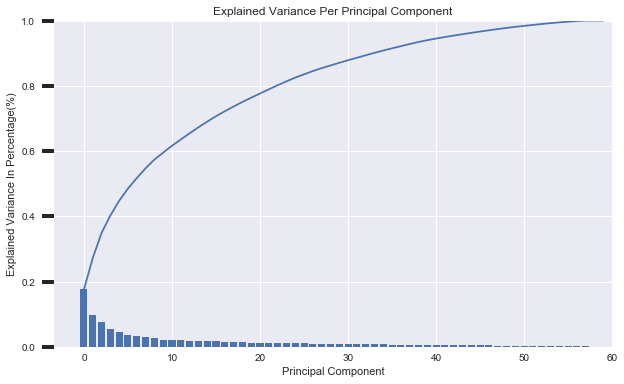

In [114]:
# Create a screen plot using screePlot function
screePlot(pca)

In [115]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_2 = PCA(n_components=46)
pca_apply_2 = pca_2.fit_transform(general_population)

### Discussion 2.2: Perform Dimensionality Reduction. 

After observing the above screeplot, we found out that after 46 features, the explained variance levels off. Also, the cumulative explained variance becomes 1. Hence, we chose 46 features to apply for the PCA

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [116]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# Import the necessary library
import operator 

def weights(pca, i):
    weight = {}
    for count, feat in enumerate(general_population.columns):
        weight[feat] = pca.components_[i][count]
    
    weight_sort = sorted(weight.items(), key=operator.itemgetter(1), reverse=True)
    
    return weight_sort



In [117]:
# Apply the weights function to get the first principal component
weight_1 = weights(pca_2,1)


In [118]:
# Print the weight_1
weight_1

[('SEMIO_PFLICHT', 0.334538556698828),
 ('decade_PRAEGENDE_JUGENDJAHRE', 0.3134903845936497),
 ('SEMIO_REL', 0.30612831317209455),
 ('SEMIO_TRADV', 0.3040836017144488),
 ('SEMIO_RAT', 0.30211707027168194),
 ('SEMIO_MAT', 0.20492106167132818),
 ('ONLINE_AFFINITAET', 0.1713458148355034),
 ('SEMIO_KULT', 0.12449371927683359),
 ('ALTER_HH', 0.11164571913866718),
 ('SEMIO_DOM', 0.09906462043937056),
 ('SEMIO_KAEM', 0.09399013670923993),
 ('SEMIO_FAM', 0.08514266601811811),
 ('movement_PRAEGENDE_JUGENDJAHRE', 0.04219996026700853),
 ('ANZ_PERSONEN', 0.04188746755407513),
 ('SEMIO_KRIT', 0.03928117201065865),
 ('PLZ8_ANTG1', 0.036572242811299664),
 ('PLZ8_GBZ', 0.030317150574128073),
 ('INNENSTADT', 0.02963026705252433),
 ('KONSUMNAEHE', 0.027187642226161945),
 ('OST_WEST_KZ_W', 0.027034916849302475),
 ('BALLRAUM', 0.02338590734591712),
 ('HH_EINKOMMEN_SCORE', 0.023239425611102937),
 ('KBA05_ANTG1', 0.022640392878425102),
 ('GEBAEUDETYP_RASTER', 0.02082473927609414),
 ('MOBI_REGIO', 0.02015498

In [119]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_2 = weights(pca_2,2)


# Print the weight_2 for the second principal component
weight_2


[('SEMIO_VERT', 0.3891893635364619),
 ('SEMIO_FAM', 0.32657536185734015),
 ('SEMIO_KULT', 0.322069229751937),
 ('SEMIO_SOZ', 0.28541279820823817),
 ('SEMIO_MAT', 0.15889853994309072),
 ('FINANZ_MINIMALIST', 0.110167383782108),
 ('SEMIO_REL', 0.10665397820769473),
 ('W_KEIT_KIND_HH', 0.0557552923526297),
 ('OST_WEST_KZ_O', 0.04352145848256074),
 ('RETOURTYP_BK_S', 0.033623530428660606),
 ('BALLRAUM', 0.03170217263034872),
 ('MIN_GEBAEUDEJAHR', 0.030278581966318056),
 ('INNENSTADT', 0.022527896670279653),
 ('FINANZ_VORSORGER', 0.01997969973804209),
 ('KONSUMNAEHE', 0.01669029896566067),
 ('KKK', 0.01564620402216089),
 ('ALTER_HH', 0.011349894414385856),
 ('wealth_CAMEO_INTL_2015', 0.008950233691968162),
 ('REGIOTYP', 0.008852276758621078),
 ('ARBEIT', 0.006656160523136051),
 ('KBA05_GBZ', 0.005888626613033478),
 ('GREEN_AVANTGARDE', 0.005825568520692936),
 ('GEBAEUDETYP_RASTER', 0.004742327701659489),
 ('SEMIO_TRADV', 0.0036993187309375636),
 ('MOBI_REGIO', 0.0034513193016330115),
 ('ANZ

In [120]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weight_3 = weights(pca_2,3)


# Print the weight_3 for the third principal component
weight_3

[('GREEN_AVANTGARDE', 0.41975327455495404),
 ('EWDICHTE', 0.2590352234690711),
 ('ORTSGR_KLS9', 0.248247505328194),
 ('ONLINE_AFFINITAET', 0.14484200775783956),
 ('PLZ8_HHZ', 0.14147979140459188),
 ('OST_WEST_KZ_W', 0.13657207697866466),
 ('PLZ8_ANTG2', 0.1204659856832368),
 ('ANZ_PERSONEN', 0.11744552970578401),
 ('FINANZ_MINIMALIST', 0.10976116033923256),
 ('PLZ8_ANTG3', 0.10814955832355827),
 ('RELAT_AB', 0.10502806767325197),
 ('KBA05_ANTG1', 0.08773654348772092),
 ('PLZ8_ANTG4', 0.08628945805779607),
 ('ALTER_HH', 0.08570340428501809),
 ('SEMIO_VERT', 0.06677709184312396),
 ('SEMIO_DOM', 0.06396493795686388),
 ('ANZ_TITEL', 0.05524432055600056),
 ('MOBI_REGIO', 0.05509980151559654),
 ('ARBEIT', 0.05255309225306372),
 ('KBA13_ANZAHL_PKW', 0.05158189397624709),
 ('KBA05_GBZ', 0.045958707728208016),
 ('ANZ_HH_TITEL', 0.04574752131391714),
 ('lifeStage_CAMEO_INTL_2015', 0.04231682643420586),
 ('SEMIO_FAM', 0.038742379653665455),
 ('SEMIO_TRADV', 0.038440617817763964),
 ('SEMIO_KAEM', 

### Discussion 2.3: Interpret Principal Components. 

We created a function to get the principal component and applied it to get the first 3 principal components. By observing those principal components, we found out that we can interpret some relationships between both the positive and the negative weights as well as the positive or negative values together. Eg: the first principal component 'SEMIO_PFLICHT' with positive weight as opposed to 'ALTERSKATEGORIE_GROB' with negative weight. This means that if 'SEMIO_PFLICHT' increases, the 'ALTERSKATEGORIE_GROB' goes down. Also, looking at some of the features such as 'SEMIO_VERT','SEMIO_FAM', etc, which belongs to the same category, it seems that they will have similar trends if we increase or decrease their value. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [121]:
# Import the necessary library for KMEANS
from sklearn.cluster import KMeans

# the following function returns the kmeans score regarding SSE(sum of squared error)
def kmeans_score(data, centroid):
    
    
    #instantiate kmeans
    kmeans = KMeans(n_clusters=centroid)

    # Then fit the model to your data using the fit method
    kmeans_model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(kmeans_model.score(data))
    
    return score

In [122]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

scores_list = []
centroids = list(range(1,30,2))

for i in centroids:
    scores_list.append(kmeans_score(pca_apply_2, i))

    

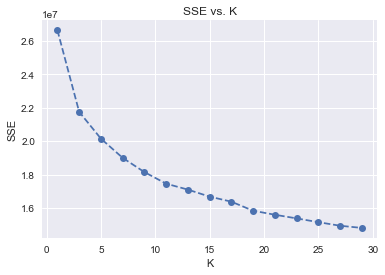

In [123]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centroids, scores_list, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [124]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=20)
model_gen = kmeans.fit(pca_apply_2)


In [125]:
#Make prediction
model_gen_pred = model_gen.predict(pca_apply_2)

### Discussion 3.1: Apply Clustering to General Population. 

Observing the above graph, we found that the score keeps decreasing. There is no obvious elbow in the above graph. Hence, we decided to choose 20 clusters because the rate the change of slope seems to slow down at that point.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [126]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [127]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [128]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
clean_customers = clean_data(customers)


In [139]:
clean_customers.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,decade_PRAEGENDE_JUGENDJAHRE,movement_PRAEGENDE_JUGENDJAHRE,wealth_CAMEO_INTL_2015,lifeStage_CAMEO_INTL_2015
0,3.0,3.0,4.0,2.0,0,5.0,4.0,5.0,4.0,6.0,...,3.0,3.0,5.0,1.0,0,1,4,1,4,1
1,3.0,5.0,5.0,3.0,1,3.0,6.0,4.0,4.0,4.0,...,5.0,3.0,7.0,5.0,0,1,2,0,3,4
2,3.0,5.0,5.0,2.0,1,3.0,6.0,5.0,4.0,6.0,...,5.0,3.0,6.0,1.0,0,1,3,0,1,5
3,2.0,2.0,2.0,3.0,0,3.0,7.0,7.0,6.0,3.0,...,1.0,3.0,8.0,5.0,0,1,6,1,4,1
4,4.0,3.0,5.0,4.0,0,5.0,6.0,4.0,2.0,4.0,...,3.0,1.0,3.0,1.0,0,1,3,1,4,3


In [140]:
# Check whether our clean customer data has the same features as the cleaned and re-engineered population features
list(gen_pop_dw2.columns) == list(clean_customers.columns)

True

In [ ]:
gen_pop_columns = list(gen_pop_dw2.columns)

In [141]:
# Save the cleaned customer data because the above step take a lot of time
clean_customers.to_csv('clean_customers.csv', sep=';', index = False)

In [145]:
clean_cust = pd.read_csv('clean_customers.csv', sep =';')

In [147]:
#Normalize the cleaned customer data
clean_cust[clean_cust.columns] = scale.transform(clean_cust[clean_cust.columns].values)


In [148]:
# View the clean customers normalized data set
clean_cust.head()

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,decade_PRAEGENDE_JUGENDJAHRE,movement_PRAEGENDE_JUGENDJAHRE,wealth_CAMEO_INTL_2015,lifeStage_CAMEO_INTL_2015
0,0.019590,-0.319418,0.091997,-1.109296,-0.470793,1.017392,-0.265648,0.345585,-0.201614,0.978569,...,-0.291169,-0.217162,-0.185185,-1.581644,-0.507563,0.507563,-0.275037,0.470793,0.399545,-1.164853
1,0.019590,1.674311,1.021713,-0.231410,2.124077,-0.383845,0.901737,-0.275462,-0.201614,-0.194867,...,1.506806,-0.217162,0.684706,1.372191,-0.507563,0.507563,-1.884154,-2.124077,-0.304132,0.847947
2,0.019590,1.674311,1.021713,-1.109296,2.124077,-0.383845,0.901737,0.345585,-0.201614,0.978569,...,1.506806,-0.217162,0.249761,-1.581644,-0.507563,0.507563,-1.079595,-2.124077,-1.711485,1.518881
3,-1.482879,-1.316282,-1.767436,-0.231410,-0.470793,-0.383845,1.485430,1.587679,1.162518,-0.781585,...,-2.089144,-0.217162,1.119652,1.372191,-0.507563,0.507563,1.334080,0.470793,0.399545,-1.164853
4,1.522059,-0.319418,1.021713,0.646476,-0.470793,1.017392,0.901737,-0.275462,-1.565745,-0.194867,...,-0.291169,-2.257526,-1.055076,-1.581644,-0.507563,0.507563,-1.079595,0.470793,0.399545,0.177014


In [149]:
#transform the customers data using pca object
clean_cust_pca = pca_2.transform(clean_cust)

In [150]:
#predict clustering using the kmeans object
pred_clean_cust = model_gen.predict(clean_cust_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

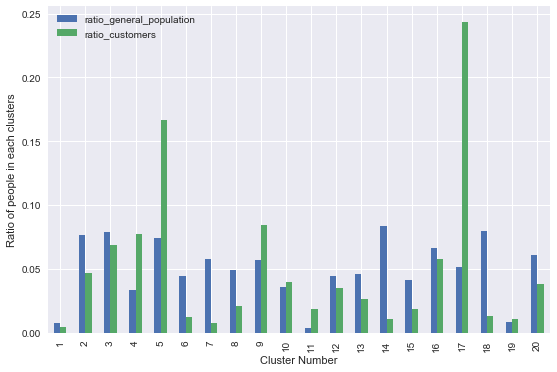

In [167]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

y = []
for i in range(1,21):
    y.append(i)
    
general_population_ratio = []
customer_population_ratio = []

for i in range(len(y)):
    general_population_ratio.append((model_gen_pred == i).sum() / len(model_gen_pred))
    customer_population_ratio.append((pred_clean_cust == i).sum() / len(pred_clean_cust))

#Create a data frame to include the cluster-number and the ratio of general & customer population    
plot_df = pd.DataFrame({'cluster_number': y, 'ratio_general_population': general_population_ratio, 'ratio_customers': customer_population_ratio})

plot_df.plot(x='cluster_number', y = ['ratio_general_population', 'ratio_customers'], kind='bar', figsize=(9,6))
plt.xlabel('Cluster Number')
plt.ylabel('Ratio of people in each clusters')
plt.show()




In [165]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cust_data = scale.inverse_transform(pca_2.inverse_transform(clean_cust_pca[np.where(pred_clean_cust==17)])).round()

cust_data_df = pd.DataFrame(data = cust_data,
          index = np.array(range(0, cust_data.shape[0])),
          columns = clean_cust.columns)

cust_data.head(10)



,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,decade_PRAEGENDE_JUGENDJAHRE,movement_PRAEGENDE_JUGENDJAHRE,wealth_CAMEO_INTL_2015,lifeStage_CAMEO_INTL_2015
0,3.0,2.0,2.0,2.0,1.0,4.0,4.0,4.0,6.0,4.0,...,3.0,3.0,3.0,4.0,-0.0,1.0,6.0,-0.0,2.0,5.0
1,2.0,4.0,4.0,2.0,0.0,2.0,2.0,5.0,5.0,7.0,...,5.0,1.0,2.0,1.0,-0.0,1.0,5.0,1.0,2.0,5.0
2,3.0,4.0,5.0,4.0,0.0,2.0,6.0,4.0,7.0,5.0,...,2.0,3.0,2.0,2.0,0.0,1.0,4.0,1.0,2.0,3.0
3,2.0,4.0,5.0,2.0,-0.0,2.0,2.0,2.0,7.0,7.0,...,4.0,1.0,4.0,1.0,-0.0,1.0,6.0,1.0,2.0,2.0
4,2.0,4.0,2.0,3.0,0.0,2.0,2.0,2.0,5.0,7.0,...,5.0,3.0,6.0,4.0,0.0,1.0,6.0,1.0,2.0,4.0
5,3.0,2.0,3.0,3.0,1.0,1.0,2.0,2.0,7.0,4.0,...,5.0,3.0,5.0,2.0,0.0,1.0,6.0,-0.0,4.0,4.0
6,2.0,3.0,4.0,2.0,-0.0,2.0,2.0,5.0,7.0,7.0,...,3.0,2.0,3.0,2.0,-0.0,1.0,4.0,1.0,4.0,3.0
7,3.0,5.0,5.0,4.0,-0.0,5.0,2.0,4.0,7.0,4.0,...,3.0,3.0,6.0,3.0,-0.0,1.0,3.0,1.0,3.0,3.0
8,3.0,4.0,5.0,3.0,-0.0,3.0,2.0,4.0,6.0,4.0,...,5.0,2.0,4.0,3.0,-0.0,1.0,3.0,1.0,2.0,2.0
9,2.0,3.0,4.0,2.0,0.0,5.0,2.0,5.0,5.0,7.0,...,3.0,3.0,7.0,5.0,-0.0,1.0,4.0,1.0,2.0,5.0


In [166]:
gen_pop_data = scale.inverse_transform(pca_2.inverse_transform(pca_apply_2[np.where(model_gen_pred==17)])).round()
gen_pop_data_df = pd.DataFrame(data = gen_pop_data,
          index = np.array(range(0, gen_pop_data.shape[0])),
          columns = general_population.columns)
gen_pop_data.head(10)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,decade_PRAEGENDE_JUGENDJAHRE,movement_PRAEGENDE_JUGENDJAHRE,wealth_CAMEO_INTL_2015,lifeStage_CAMEO_INTL_2015
0,3.0,3.0,5.0,5.0,0.0,3.0,2.0,4.0,7.0,4.0,...,5.0,2.0,2.0,3.0,-0.0,1.0,2.0,1.0,5.0,4.0
1,2.0,3.0,5.0,3.0,-0.0,4.0,2.0,5.0,5.0,7.0,...,5.0,4.0,5.0,3.0,0.0,1.0,5.0,1.0,2.0,2.0
2,2.0,3.0,5.0,2.0,0.0,1.0,2.0,5.0,5.0,7.0,...,4.0,3.0,5.0,2.0,0.0,1.0,5.0,1.0,2.0,5.0
3,2.0,4.0,5.0,2.0,0.0,1.0,2.0,5.0,5.0,7.0,...,6.0,3.0,4.0,2.0,0.0,1.0,5.0,1.0,2.0,5.0
4,2.0,3.0,5.0,4.0,0.0,4.0,2.0,5.0,5.0,7.0,...,4.0,1.0,1.0,1.0,-0.0,1.0,6.0,1.0,2.0,2.0
5,2.0,4.0,2.0,2.0,0.0,2.0,2.0,2.0,5.0,7.0,...,4.0,4.0,8.0,4.0,-0.0,1.0,6.0,1.0,2.0,5.0
6,2.0,5.0,5.0,4.0,0.0,3.0,3.0,2.0,7.0,7.0,...,5.0,5.0,3.0,4.0,1.0,-0.0,3.0,1.0,2.0,5.0
7,2.0,4.0,2.0,2.0,-0.0,3.0,3.0,5.0,5.0,7.0,...,3.0,2.0,3.0,1.0,-0.0,1.0,6.0,1.0,2.0,5.0
8,2.0,3.0,2.0,2.0,-0.0,1.0,3.0,5.0,4.0,7.0,...,5.0,2.0,5.0,3.0,-0.0,1.0,6.0,1.0,4.0,1.0
9,3.0,3.0,2.0,2.0,1.0,2.0,2.0,4.0,7.0,4.0,...,4.0,4.0,7.0,5.0,-0.0,1.0,6.0,-0.0,2.0,4.0


#### Obervation: After observing the above data and looking at the respective reference from the data dictionary, we can see that this cluster belongs to people young people, with mostly avg to high financial topology

In [174]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cust_data_2 = scale.inverse_transform(pca_2.inverse_transform(clean_cust_pca[np.where(pred_clean_cust==14)])).round()
cust_data_df2 = pd.DataFrame(data=cust_data_2,
          index=np.array(range(0, cust_data_2.shape[0])),
          columns=clean_cust.columns)
cust_data_df2.head(10)


,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,decade_PRAEGENDE_JUGENDJAHRE,movement_PRAEGENDE_JUGENDJAHRE,wealth_CAMEO_INTL_2015,lifeStage_CAMEO_INTL_2015
0,4.0,5.0,4.0,2.0,-0.0,3.0,6.0,4.0,3.0,6.0,...,4.0,4.0,4.0,3.0,1.0,0.0,3.0,1.0,4.0,3.0
1,3.0,5.0,3.0,2.0,1.0,1.0,3.0,4.0,4.0,4.0,...,3.0,5.0,4.0,4.0,1.0,0.0,5.0,0.0,4.0,3.0
2,3.0,5.0,5.0,4.0,-0.0,2.0,2.0,4.0,4.0,4.0,...,3.0,5.0,6.0,5.0,1.0,0.0,2.0,1.0,4.0,4.0
3,3.0,5.0,5.0,2.0,0.0,3.0,2.0,3.0,2.0,4.0,...,3.0,4.0,2.0,3.0,1.0,-0.0,4.0,1.0,2.0,5.0
4,3.0,5.0,3.0,2.0,0.0,3.0,6.0,6.0,4.0,4.0,...,5.0,5.0,5.0,5.0,1.0,0.0,4.0,1.0,4.0,4.0
5,3.0,5.0,5.0,4.0,0.0,3.0,6.0,2.0,4.0,4.0,...,3.0,3.0,4.0,2.0,1.0,-0.0,3.0,1.0,2.0,4.0
6,4.0,5.0,3.0,2.0,0.0,3.0,6.0,4.0,2.0,4.0,...,2.0,4.0,1.0,3.0,1.0,-0.0,4.0,1.0,2.0,4.0
7,4.0,5.0,5.0,4.0,-0.0,5.0,6.0,4.0,5.0,4.0,...,3.0,4.0,4.0,3.0,1.0,0.0,3.0,1.0,5.0,5.0
8,4.0,5.0,4.0,4.0,-0.0,3.0,4.0,3.0,2.0,4.0,...,4.0,3.0,2.0,2.0,1.0,0.0,4.0,1.0,4.0,1.0
9,3.0,4.0,3.0,2.0,-0.0,4.0,6.0,4.0,4.0,4.0,...,4.0,4.0,2.0,3.0,1.0,-0.0,4.0,1.0,2.0,4.0


In [175]:
gen_pop_data_2 = scale.inverse_transform(pca_2.inverse_transform(pca_apply_2[np.where(model_gen_pred==14)])).round()
gen_pop_data_df2 = pd.DataFrame(data = gen_pop_data_2, index=np.array(range(0, gen_pop_data_2.shape[0])), columns=general_population.columns)
gen_pop_data_df2.head(10)

,ALTERSKATEGORIE_GROB,FINANZ_MINIMALIST,FINANZ_VORSORGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,decade_PRAEGENDE_JUGENDJAHRE,movement_PRAEGENDE_JUGENDJAHRE,wealth_CAMEO_INTL_2015,lifeStage_CAMEO_INTL_2015
0,4.0,4.0,4.0,5.0,-0.0,5.0,6.0,6.0,5.0,6.0,...,3.0,4.0,3.0,2.0,1.0,-0.0,3.0,1.0,4.0,3.0
1,4.0,4.0,4.0,4.0,-0.0,3.0,6.0,6.0,4.0,4.0,...,3.0,3.0,3.0,1.0,1.0,0.0,3.0,1.0,2.0,5.0
2,3.0,2.0,3.0,4.0,0.0,3.0,3.0,2.0,4.0,5.0,...,3.0,4.0,3.0,5.0,1.0,0.0,5.0,1.0,4.0,1.0
3,3.0,5.0,3.0,2.0,-0.0,3.0,3.0,6.0,4.0,4.0,...,3.0,4.0,4.0,3.0,1.0,0.0,4.0,1.0,2.0,5.0
4,3.0,2.0,5.0,5.0,0.0,5.0,5.0,2.0,3.0,3.0,...,2.0,4.0,4.0,3.0,1.0,-0.0,4.0,1.0,4.0,5.0
5,3.0,3.0,3.0,3.0,0.0,3.0,3.0,4.0,5.0,6.0,...,3.0,5.0,3.0,5.0,1.0,0.0,4.0,1.0,2.0,3.0
6,4.0,5.0,3.0,2.0,-0.0,3.0,3.0,5.0,3.0,4.0,...,4.0,4.0,3.0,3.0,1.0,-0.0,4.0,1.0,1.0,4.0
7,4.0,4.0,5.0,4.0,-0.0,3.0,3.0,4.0,3.0,6.0,...,3.0,5.0,4.0,5.0,1.0,-0.0,3.0,1.0,2.0,5.0
8,3.0,5.0,5.0,3.0,-0.0,4.0,6.0,4.0,4.0,4.0,...,4.0,5.0,2.0,5.0,1.0,0.0,3.0,1.0,4.0,3.0
9,3.0,3.0,3.0,4.0,0.0,3.0,2.0,3.0,4.0,2.0,...,3.0,5.0,2.0,5.0,1.0,-0.0,4.0,1.0,4.0,1.0


#### Observation: After observing the above data and looking at the respective reference from the data dictionary, we can see that this cluster belongs to older people with mostly low to avg financial topology. 

### Discussion 3.3: Compare Customer Data to Demographics Data

Looking at the bar plot above, we can clearly see that for half of clusters there is a good match between the general population and the customers population. So, the company can use this info to select a part of the general population for their business. We must consider the fact that we have removed 25 columns mostly mixed and categorical features, which contain very important information. I’d say if we kept those features we would see much better match between the general population and the customers population

By observing the above plot, we noticed that the following:
- Cluster number [1, 3,12, 16, 19]  form the company's universal customer base because their ratios are fairly similar(+1%/-1% change)
- Cluster number [2, 6, 7, 8, 13, 14, 15, 18, 20] represents audience that are out of target demographics for the company.
- Cluster number [4, 5, 9, 10, 17] represents audience that are the target audience for the company and these audience form the core customer base of the company.

Using the above information the company can direct the marketing campaigns accordingly and increase their sales. 

However, we need to also consider the fact that we have removed 25 columns. May be we would have seen a different match, if we had information that would have not let us drop those columns


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.